# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Нужно построить модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

## Подготовка данных

In [1]:
# Подключаем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Разбиение на обучающую, валидационную и тестовую выборку
from sklearn.model_selection import train_test_split

# Масштабируемость модели
from sklearn.preprocessing import StandardScaler

# и для машинного обучения разными способами:
# - Случайный лес
from sklearn.ensemble import RandomForestClassifier
# - Решающее дерево
from sklearn.tree import DecisionTreeClassifier
# - Модель на адекватность
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (
    # Точность модели
    accuracy_score,
    # Матрицы ошибок (для борьбы с дисбалансом)
    confusion_matrix, 
    # Полнота
    recall_score, 
    # Точность
    precision_score, 
    # F1-мера
    f1_score,
    # Метрика AUC-ROC
    roc_auc_score,
    roc_curve
)

# Контроль выборки
from sklearn.utils import shuffle

In [2]:
# Получаем датасет
try:
    try:
        df = pd.read_csv('/datasets/Churn.csv')
    except:
        df = pd.read_csv('datasets/Churn.csv')
        # Узнаем, что в нем
    df.info()
except:
    print('Отсутствует датасет. Проверьте путь файла')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
# Проверим на наличие пропущенных значений
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Себе на пометку:
Если в каком то признаке пустые значения, то его следует заполнять, иначе выводит ошибку такого рода: "Input contains NaN, infinity or a value too large for dtype('float32')"


In [5]:
# Заполняем пропуски медианным значением
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

In [6]:
# Снова проверим на пропущенные значения
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## Исследование задачи

In [7]:
# Убираем лишние: фамилии, айдишники, порядковые номера
df = df[['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']]

In [8]:
# Уклоняемся от дамми-ловушек
df_ohe = pd.get_dummies(df, drop_first=True)

In [9]:
#код ревюьера
df_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


In [10]:
# Получаем признак и цель 
features = df_ohe.drop('Exited', axis=1)
target = df_ohe['Exited']

In [11]:
# Как обычно, будем разделять 60% данных для обучающей выборки, а features_temp и target_temp будут временным датафреймом
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size= (1 - 0.6), random_state=12345) 

In [12]:
# А тестовая и валидационная - по 20% данных
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=(1 - 0.5), random_state=12345)

In [13]:
# Вызов библиотеки для отключения предупреждения
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Масштабируем признаки: обучающую, валидационную и тестовую выборку
scaler = StandardScaler()

# Выберем подходящие признаки по порядку (количественные, а не категориальные)
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

scaler.fit(features_train[numeric])

# Преобразуем обучающую, валидационную и тестовую выборки функцией transform()
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# Чтобы предупреждение не появлялось
pd.options.mode.chained_assignment = None

In [15]:
# Проверим
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


In [16]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.082277,1.232271,1,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.082277,0.600563,1,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.737696,1.027098,2,0,1,1.503095,1,0,1
1247,-1.457915,-1.417129,0.354288,-1.233163,2,1,0,-1.071061,0,0,1
3716,0.130961,-1.132419,-1.101690,1.140475,1,0,0,1.524268,1,0,0


In [17]:
example_1 = features_train[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']]

In [18]:
example_1.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7479,-0.886751,-0.373192,1.082277,1.232271,1,1,0,-0.187705
3411,0.608663,-0.183385,1.082277,0.600563,1,0,0,-0.333945
6027,2.052152,0.480939,-0.737696,1.027098,2,0,1,1.503095
1247,-1.457915,-1.417129,0.354288,-1.233163,2,1,0,-1.071061
3716,0.130961,-1.132419,-1.101690,1.140475,1,0,0,1.524268


Все в порядке, переходим дальше

In [19]:
# Примененим методом решающего дерева, меняя гиперпараметры
best_model = None
best_result = 0

for depth in range(1, 10):
    # Обучим модель с заданной глубиной дерева
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    
    # Обучим модель
    model.fit(features_train, target_train)
    
    # Получим предсказания модели
    predicted_valid = model.predict(features_valid)
    
    # Посчитаем качество модели
    result = accuracy_score(target_valid, predicted_valid) 
    
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
    
    print("max_depth =", depth, ": ", end='')
    print(result)
    
print()
print("Accuracy наилучшей модели на валидационной выборке:", best_result)

max_depth = 1 : 0.791
max_depth = 2 : 0.824
max_depth = 3 : 0.838
max_depth = 4 : 0.852
max_depth = 5 : 0.853
max_depth = 6 : 0.858
max_depth = 7 : 0.8505
max_depth = 8 : 0.85
max_depth = 9 : 0.845

Accuracy наилучшей модели на валидационной выборке: 0.858


In [20]:
# Узнаем матрицу ошибок, чтобы выявлять полноту, точность и F1
confusion_matrix(target_valid,predicted_valid)

array([[1490,   92],
       [ 218,  200]])

In [21]:
# Выявляем полноту, т.е. долю TP-ответов среди всех, у которых истинная метка 1. 
# Хорошо, когда значение recall близко к единице: модель хорошо ищет положительные объекты. 
# Если ближе к нулю — модель надо перепроверить и починить.

recall_score(target_valid, predicted_valid)

0.4784688995215311

Полнота близка к 0.5 , значит модель неплоха

In [22]:
# Выявляем точность, т.е. как много отрицательных ответов нашла модель, пока искала положительные. 
# Чем больше отрицательных, тем ниже точность.
precision_score(target_valid, predicted_valid)

0.684931506849315

Точность близка к 1, значит присутствуют значителльное кол-во отрицательных ответов

In [23]:
# Выявляем F1-меру, т.е. соотношение полноты и точности
f1_score(target_valid, predicted_valid)

0.5633802816901409

Получилось меньше заявленного требования, примерно на  на 3%

In [24]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

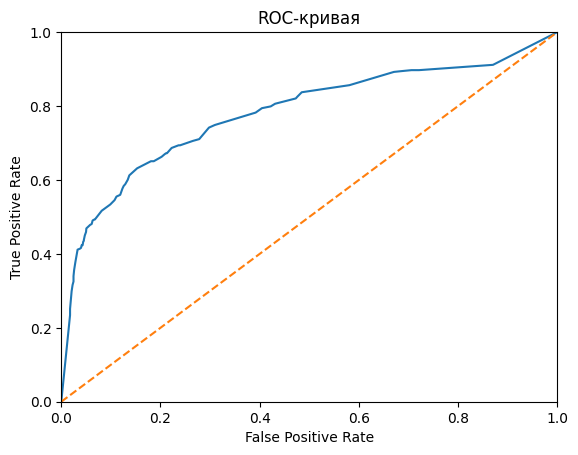

In [25]:
# Изображаем ROC-кривую
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

In [26]:
# А теперь применим методом случайного леса
best_model = None
best_result = 0
for est in range(1, 21):
    # Обучим модель с заданным количеством деревьев
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    
    # Обучим модель на тренировочной выборке
    model.fit(features_train, target_train) 
    
    # Посчитаем качество модели на валидационной выборке
    model.score(features_valid, target_valid) 
    
    predicted_valid = model.predict(features_valid)
    
    result = f1_score(target_valid, predicted_valid)
    print('F1:', result)
    
    if result > best_result:
        # Сохраним наилучшую модель
        best_model = model
        # Сохраним наилучшее значение метрики accuracy на валидационных данных
        best_result = result

print()
print("F1-мера наилучшей модели на валидационной выборке:", best_result)

F1: 0.49440715883668906
F1: 0.4507042253521127
F1: 0.5400516795865634
F1: 0.48916408668730654
F1: 0.5551020408163265
F1: 0.5402985074626865
F1: 0.5804676753782668
F1: 0.5440956651718983
F1: 0.5633802816901409
F1: 0.5522388059701492
F1: 0.5734463276836158
F1: 0.551622418879056
F1: 0.5734463276836158
F1: 0.5502958579881656
F1: 0.5606936416184971
F1: 0.5457271364317842
F1: 0.5606936416184971
F1: 0.547085201793722
F1: 0.5573294629898404
F1: 0.5481927710843373

F1-мера наилучшей модели на валидационной выборке: 0.5804676753782668


In [27]:
# Узнаем матрицу ошибок, чтобы выявлять полноту, точность и F1
confusion_matrix(target_valid,predicted_valid)

array([[1518,   64],
       [ 236,  182]])

In [28]:
# Выявляем полноту, т.е. долю TP-ответов среди всех, у которых истинная метка 1. 
# Хорошо, когда значение recall близко к единице: модель хорошо ищет положительные объекты. 
# Если ближе к нулю — модель надо перепроверить и починить.

recall_score(target_valid, predicted_valid)

0.4354066985645933

In [29]:
# Выявляем точность, т.е. как много отрицательных ответов нашла модель, пока искала положительные. 
# Чем больше отрицательных, тем ниже точность.
precision_score(target_valid, predicted_valid)

0.7398373983739838

In [30]:
# Выявляем F1-меру, т.е. соотношение полноты и точности
f1_score(target_valid, predicted_valid)

0.5481927710843373

Здесь получилось таким же, ничего не поменялось

In [31]:
# Проверим модель на адекватность

# Устанавливаем стратегию прогноза как "самый частый случай", 
# т.е. частую метку класса в наблюдаемом аргументе target, 
# переданном для соответствия
dummy_model = DummyClassifier(strategy = 'constant', constant=1)

# Обучим модель
dummy_model.fit(features_train, target_train)

# Создаем модель, указав стратению как "самый частый случай"
DummyClassifier(strategy = 'most_frequent')

# Получим предсказания модели
dummy_model.predict(features_train)

# Посчитаем качество модели
dummy_model.score(features_train, target_train)

0.19933333333333333

In [32]:
f1_score(dummy_model.predict(features_test), target_test)

0.3491539413949649

Здесь как-то не очень вышло, совсем низкий показатель

Здесь вышло, что оба методы обучения F1-меры показались себя одинаковыми

## Борьба с дисбалансом

In [33]:
confusion_matrix(target_valid,predicted_valid)

array([[1518,   64],
       [ 236,  182]])

Здесь получается, что 
- TN; FP
- FN; TP


TN - истинно отрицательные ответы (1443)

FP - ложноотрицательные ответы (139)

FN - ложноположительные ответы (220)

TP - истинно положительные ответы (198)

Здесь значения TN намного превысили остальных

In [34]:
# Выявляем полноту, т.е. долю TP-ответов среди всех, у которых истинная метка 1. 
# Хорошо, когда значение recall близко к единице: модель хорошо ищет положительные объекты. 
# Если ближе к нулю — модель надо перепроверить и починить.

recall_score(target_valid, predicted_valid)

0.4354066985645933

Здесь приблизилась к золотой середине, ни плохо, ни слишком идеально

In [35]:
# Выявляем точность, т.е. как много отрицательных ответов нашла модель, пока искала положительные. 
# Чем больше отрицательных, тем ниже точность.
precision_score(target_valid, predicted_valid)

0.7398373983739838

Здесь точность нам удовлетворит

In [36]:
# Выявляем F1-меру, т.е. соотношение полноты и точности
f1_score(target_valid, predicted_valid)

0.5481927710843373

Здесь получилось меньше по заявленному требованию - 0.59

In [37]:
# Создадим функуцию для контроля выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [38]:
# Вызываем функцию
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [39]:
# Попробуем увеличить F1-меру методом "Решающего дерева", меняя гиперпараметры
best_model = None
best_result = 0

for depth in range(1, 21):
    # Обучим модель с заданной глубиной дерева
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    
    # Обучим модель
    model.fit(features_upsampled, target_upsampled)
    
    # Получим предсказания модели
    predicted_valid = model.predict(features_valid)
    
    # Посчитаем f1-меру модели
    result = f1_score(target_valid, predicted_valid) 
    
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
    
    print("max_depth =", depth, ": F1: ", end='')
    print(result)
    
print()
print("F1 наилучшей модели на валидационной выборке:", best_result, 'Глубина:', best_depth)

max_depth = 1 : F1: 0.4994903160040775
max_depth = 2 : F1: 0.541015625
max_depth = 3 : F1: 0.541015625
max_depth = 4 : F1: 0.5277777777777778
max_depth = 5 : F1: 0.5963791267305644
max_depth = 6 : F1: 0.5581835383159887
max_depth = 7 : F1: 0.5524752475247525
max_depth = 8 : F1: 0.5408560311284047
max_depth = 9 : F1: 0.5405940594059405
max_depth = 10 : F1: 0.5159420289855072
max_depth = 11 : F1: 0.5351521511017839
max_depth = 12 : F1: 0.5117227319062181
max_depth = 13 : F1: 0.5119825708061002
max_depth = 14 : F1: 0.4994375703037121
max_depth = 15 : F1: 0.486796785304248
max_depth = 16 : F1: 0.46964490263459335
max_depth = 17 : F1: 0.4827586206896552
max_depth = 18 : F1: 0.4860943168077388
max_depth = 19 : F1: 0.48792270531400966
max_depth = 20 : F1: 0.48375451263537905

F1 наилучшей модели на валидационной выборке: 0.5963791267305644 Глубина: 5


In [40]:
# А теперь применим методом случайного леса
best_model = None
best_result = 0
for est in range(1, 26):
    # Обучим модель с заданным количеством деревьев
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    
    # Обучим модель на тренировочной выборке
    model.fit(features_upsampled, target_upsampled)
    
    # Посчитаем качество модели на валидационной выборке
    model.score(features_valid, target_valid) 
     
    # Получим предсказания модели
    predicted_valid = model.predict(features_valid)
    
    # Посчитаем f1-меру модели
    result = f1_score(target_valid, predicted_valid) 
    
    if result > best_result:
        # Сохраним наилучшую модель
        best_model = model
        # Сохраним наилучшее значение метрики accuracy на валидационных данных
        best_result = result
        
    print("max_depth =", depth, ": F1: ", end='')
    print(result)
    
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)

max_depth = 20 : F1: 0.4881720430107527
max_depth = 20 : F1: 0.4388059701492537
max_depth = 20 : F1: 0.5349112426035504
max_depth = 20 : F1: 0.5070422535211268
max_depth = 20 : F1: 0.5581395348837208
max_depth = 20 : F1: 0.5429362880886426
max_depth = 20 : F1: 0.558258642765685
max_depth = 20 : F1: 0.5667125171939477
max_depth = 20 : F1: 0.5819567979669631
max_depth = 20 : F1: 0.5822102425876011
max_depth = 20 : F1: 0.583547557840617
max_depth = 20 : F1: 0.5780189959294437
max_depth = 20 : F1: 0.5821474773609314
max_depth = 20 : F1: 0.5855614973262032
max_depth = 20 : F1: 0.5880829015544042
max_depth = 20 : F1: 0.5871313672922251
max_depth = 20 : F1: 0.5922077922077922
max_depth = 20 : F1: 0.5932885906040269
max_depth = 20 : F1: 0.5984455958549223
max_depth = 20 : F1: 0.5959731543624162
max_depth = 20 : F1: 0.5888456549935149
max_depth = 20 : F1: 0.5904255319148937
max_depth = 20 : F1: 0.5873221216041399
max_depth = 20 : F1: 0.5918097754293262
max_depth = 20 : F1: 0.5876288659793815

F

Наконец-то добились ожидаемого результата!

In [41]:
# Получаем предсказания
predicted_valid = model.predict(features_valid)

In [42]:
# Создадим функцию, которая будет уменьшать выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [43]:
# Вызываем функцию
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [44]:
# Попробуем увеличить F1-меру методом "Решающего дерева", меняя гиперпараметры
best_model = None
best_result = 0

for depth in range(1, 21):
    # Обучим модель с заданной глубиной дерева
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    
    # Обучим модель
    model.fit(features_downsampled, target_downsampled)
    
    # Получим предсказания модели
    predicted_valid = model.predict(features_valid)
    
    # Посчитаем качество модели
    result = f1_score(target_valid, predicted_valid) 
    
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
    
    print("max_depth =", depth, ": F1: ", end='')
    print(result)
    
print()
print("F1 наилучшей модели на валидационной выборке:", best_result, 'Глубина:', best_depth)

max_depth = 1 : F1: 0.5061845861084681
max_depth = 2 : F1: 0.5394495412844036
max_depth = 3 : F1: 0.5555555555555556
max_depth = 4 : F1: 0.5357737104825291
max_depth = 5 : F1: 0.5943204868154158
max_depth = 6 : F1: 0.5749525616698292
max_depth = 7 : F1: 0.5304659498207885
max_depth = 8 : F1: 0.5181159420289856
max_depth = 9 : F1: 0.522911051212938
max_depth = 10 : F1: 0.5135895032802249
max_depth = 11 : F1: 0.5117117117117117
max_depth = 12 : F1: 0.4881474978050922
max_depth = 13 : F1: 0.49107901444350044
max_depth = 14 : F1: 0.4982698961937717
max_depth = 15 : F1: 0.4987277353689567
max_depth = 16 : F1: 0.4891846921797005
max_depth = 17 : F1: 0.49037656903765686
max_depth = 18 : F1: 0.47619047619047616
max_depth = 19 : F1: 0.4878863826232247
max_depth = 20 : F1: 0.4878863826232247

F1 наилучшей модели на валидационной выборке: 0.5943204868154158 Глубина: 5


Результат примерно тот же, как у этого метода - случайного леса с увеличением выборком

In [45]:
# А теперь применим методом случайного леса
best_model = None
best_result = 0
for est in range(1, 21):
    # Обучим модель с заданным количеством деревьев
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    
    # Обучим модель на тренировочной выборке
    model.fit(features_downsampled, target_downsampled)
    
    # Посчитаем качество модели на валидационной выборке
    model.score(features_valid, target_valid) 
    
    # Получим предсказания модели
    predicted_valid = model.predict(features_valid)
    
    # Посчитаем f1-меру модели
    result = f1_score(target_valid, predicted_valid) 
    
    if result > best_result:
        # Сохраним наилучшую модель
        best_model = model
        # Сохраним наилучшее значение метрики accuracy на валидационных данных
        best_result = result
        
    print("max_depth =", depth, ": F1: ", end='')
    print(result)
    
print()
print("F1 наилучшей модели на валидационной выборке:", best_result)

max_depth = 20 : F1: 0.47427652733118975
max_depth = 20 : F1: 0.4972129319955407
max_depth = 20 : F1: 0.49957519116397625
max_depth = 20 : F1: 0.5211995863495346
max_depth = 20 : F1: 0.5238907849829351
max_depth = 20 : F1: 0.5629335976214073
max_depth = 20 : F1: 0.5492227979274611
max_depth = 20 : F1: 0.5795677799607073
max_depth = 20 : F1: 0.5589285714285714
max_depth = 20 : F1: 0.5764705882352942
max_depth = 20 : F1: 0.5753176043557169
max_depth = 20 : F1: 0.5896180215475024
max_depth = 20 : F1: 0.5912882298424468
max_depth = 20 : F1: 0.5901960784313726
max_depth = 20 : F1: 0.5844155844155845
max_depth = 20 : F1: 0.5974534769833496
max_depth = 20 : F1: 0.5830258302583027
max_depth = 20 : F1: 0.5916585838991271
max_depth = 20 : F1: 0.5845588235294118
max_depth = 20 : F1: 0.5903846153846154

F1 наилучшей модели на валидационной выборке: 0.5974534769833496


Здесь немного уступает модели с увеличением выборки

In [46]:
# Проверим на порог
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.5f}".format(threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.220, Полнота = 0.998, F1 = 0.36073
Порог = 0.02 | Точность = 0.220, Полнота = 0.998, F1 = 0.36073
Порог = 0.04 | Точность = 0.220, Полнота = 0.998, F1 = 0.36073
Порог = 0.06 | Точность = 0.235, Полнота = 0.988, F1 = 0.37907
Порог = 0.08 | Точность = 0.235, Полнота = 0.988, F1 = 0.37907
Порог = 0.10 | Точность = 0.253, Полнота = 0.974, F1 = 0.40158
Порог = 0.12 | Точность = 0.253, Полнота = 0.974, F1 = 0.40158
Порог = 0.14 | Точность = 0.253, Полнота = 0.974, F1 = 0.40158
Порог = 0.16 | Точность = 0.270, Полнота = 0.947, F1 = 0.42083
Порог = 0.18 | Точность = 0.270, Полнота = 0.947, F1 = 0.42083
Порог = 0.20 | Точность = 0.295, Полнота = 0.938, F1 = 0.44826
Порог = 0.22 | Точность = 0.295, Полнота = 0.938, F1 = 0.44826
Порог = 0.24 | Точность = 0.295, Полнота = 0.938, F1 = 0.44826
Порог = 0.26 | Точность = 0.316, Полнота = 0.907, F1 = 0.46848
Порог = 0.28 | Точность = 0.316, Полнота = 0.907, F1 = 0.46848


Здесь F1 больше 0.59 можно добиться методом: Случайного леса с увеличением выборки или Решающего дерева с понижением выборки. Значит по этому методу будем тестировать модели

In [47]:
# Попробуем увеличить F1-меру методом "Решающего дерева", меняя гиперпараметры
best_model = None
best_result = 0

for depth in range(1, 10):
    # Обучим модель с заданной глубиной дерева
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    
    # Обучим модель
    model.fit(features_downsampled, target_downsampled)
    
    # Получим предсказания модели
    predicted_valid = model.predict(features_valid)

In [48]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

In [49]:
auc_roc

0.7618611593343778

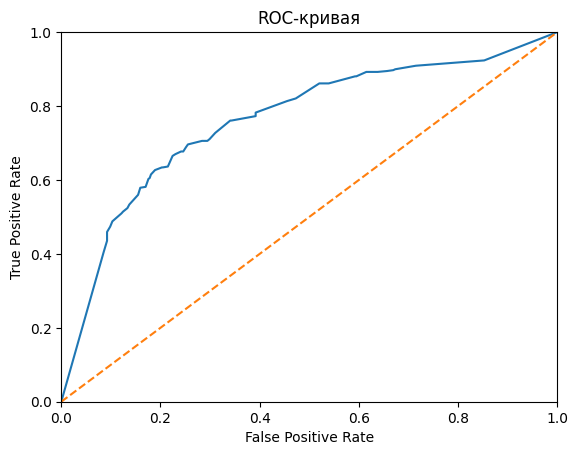

In [50]:
# Изображаем ROC-кривую
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

In [51]:
# А теперь применим методом случайного леса
best_model = None
best_result = 0
for est in range(1, 21):
    # Обучим модель с заданным количеством деревьев
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    
    # Обучим модель на тренировочной выборке
    model.fit(features_upsampled, target_upsampled)

# Получаем предсказания
predicted_valid = model.predict(features_valid)

In [52]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

In [53]:
auc_roc

0.8242413152753163

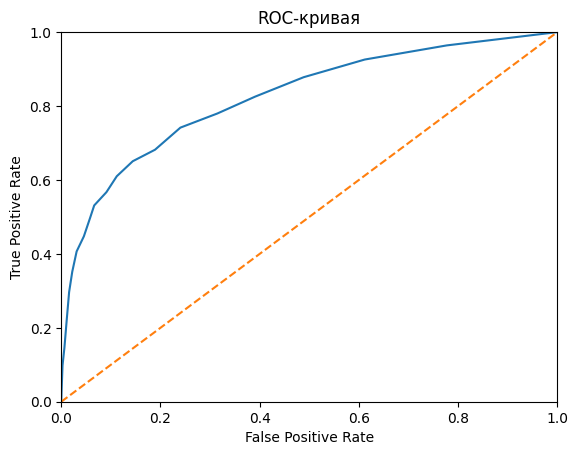

In [54]:
# Изображаем ROC-кривую
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

Здесь намного получше, чем методм "Решающее дерево" с уменьшением выборки

## Тестирование модели

In [55]:
# Протестируем лучшую модель - "Случайного леса" с увеличением выборки

# Получим предсказания обучающей модели
train_predictions = model.predict(features_train)

# Получим предсказания тестовой модели
test_predictions = model.predict(features_test)

In [56]:
print("Accuracy")
print("Обучающая выборка:", accuracy_score(target_train, train_predictions))
print("Тестовая выборка:", accuracy_score(target_test, test_predictions))

Accuracy
Обучающая выборка: 0.9996666666666667
Тестовая выборка: 0.843


Здесь модель явно переобучена, да уж плохо. Но тестовая выборка показалась неплохим результатом

In [57]:
# Выявляем полноту, т.е. долю TP-ответов среди всех, у которых истинная метка 1. 
# Хорошо, когда значение recall близко к единице: модель хорошо ищет положительные объекты. 
# Если ближе к нулю — модель надо перепроверить и починить.

recall_score(target_test, test_predictions)

0.5366430260047281

Здесь тоже самое - приблизилась к золотой середине, ни плохо, ни слишком идеально. Но по сравнению предыдующей модели здесь полнота меньше получилась

In [58]:
# Выявляем точность, т.е. как много отрицательных ответов нашла модель, пока искала положительные. 
# Чем больше отрицательных, тем ниже точность.
precision_score(target_test, test_predictions)

0.6579710144927536

Здесь точность стала более выше предыдующей

In [59]:
# Выявляем F1-меру, т.е. соотношение полноты и точности
f1_score(target_valid, predicted_valid)

0.5959731543624162

Как раз больше 0.59

In [60]:
# Создадим константную модель
target_pred_constant = pd.Series(0, index=target_test.index)

In [61]:
print("Accuracy")
print("Константная выборка:", accuracy_score(target_test, target_pred_constant))

Accuracy
Константная выборка: 0.7885


In [62]:
# Выявляем F1-меру, т.е. соотношение полноты и точности
f1_score(target_test, target_pred_constant)

0.0

Здесь константная модель получилось 0

Вывод

Самая оптимальная модель оказалась метод "Случайного леса", скорость обучения дает о себе знать, но показатели качества намного уступает "Решающего дерева".

Чтобы справиться с дисбалансом, мы увеличили и уменьшали (upsampling и downsampling) значение в 4 раза.